In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df= pd.read_csv("/content/drive/MyDrive/Doceree-HCP_Train.csv",encoding='latin-1')

In [4]:
df.columns

Index(['ID', 'DEVICETYPE', 'PLATFORM_ID', 'BIDREQUESTIP', 'USERPLATFORMUID',
       'USERCITY', 'USERZIPCODE', 'USERAGENT', 'PLATFORMTYPE', 'CHANNELTYPE',
       'URL', 'KEYWORDS', 'TAXONOMY', 'IS_HCP'],
      dtype='object')

In [5]:
df['KEYWORDS'] =df['KEYWORDS'].str.lower()

In [6]:
# data = df[['DEVICETYPE','USERCITY','USERZIPCODE','USERAGENT','PLATFORMTYPE','URL','IS_HCP']].fillna(0)
# columns = data.columns

In [7]:
data = df.copy()

In [8]:
data.drop(["TAXONOMY","KEYWORDS","CHANNELTYPE","PLATFORMTYPE","USERPLATFORMUID","BIDREQUESTIP","ID","PLATFORM_ID","DEVICETYPE"], axis=1, inplace=True)
data = data.fillna(0)

In [9]:
columns = data.columns

In [10]:
test = data.sample(20000,random_state=42)
train = data[~data.index.isin(test.index)]

In [11]:
def train_test_split(df):
  test = df.sample(20000,random_state=42)
  train = df[~df.index.isin(test.index)]
  return train, test

In [12]:
def data_preprocessing(df):
  df['KEYWORDS'] =df['KEYWORDS'].str.lower()
  df.drop(["TAXONOMY","KEYWORDS","CHANNELTYPE","PLATFORMTYPE","USERPLATFORMUID","BIDREQUESTIP","ID","PLATFORM_ID","DEVICETYPE"], axis=1, inplace=True)
  df = df.fillna(0)
  return df


#**Target Encoding**

In [13]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00


In [14]:
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_x = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [15]:
import category_encoders as ce


#Create target encoding object
encoder=ce.TargetEncoder(cols=train_x.columns, smoothing=0.2)


In [16]:
encoder

TargetEncoder(cols=Index(['USERCITY', 'USERZIPCODE', 'USERAGENT', 'URL'], dtype='object'),
              smoothing=0.2)

In [17]:
train_x_encoded = encoder.fit_transform(train_x, train_y)
test_x_encoded =encoder.transform(test_x, test_y)

In [18]:
def target_encoding(train, test):
  train_x = train.iloc[:,:-1]
  train_y = train.iloc[:,-1]
  test_x = test.iloc[:,:-1]
  test_y = test.iloc[:,-1]
  encoder=ce.TargetEncoder(cols=train_x.columns, smoothing=0.2)
  train_x_encoded = encoder.fit_transform(train_x, train_y)
  test_x_encoded =encoder.transform(test_x, test_y)
  return train_x_encoded, test_x_encoded


In [19]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [20]:
dt.fit(train_x_encoded, train_y)
y_pred = dt.predict(test_x_encoded)
y_pred_train = dt.predict(train_x_encoded)

In [21]:
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_pred,test_y))
print(accuracy_score(y_pred,test_y))

0.9798903107861061
0.9879


In [22]:
importance = dt.feature_importances_
feature_names = train_x.columns

In [23]:
importance


array([0.02226834, 0.01527671, 0.12495136, 0.83750359])

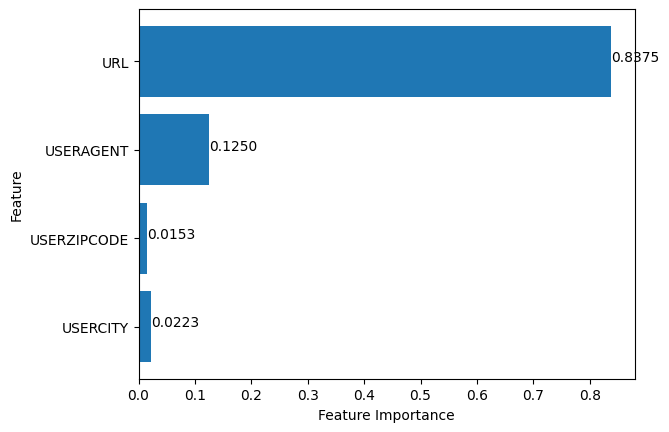

In [24]:
import matplotlib.pyplot as plt
plt.barh(range(len(importance)), importance, align = 'center')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.yticks(range(len(importance)), feature_names)
for index, value in enumerate(importance):
    plt.text(value, index, f'{value:.4f}')
plt.show()

**Count Vectorizer**

In [25]:
train_x = train_x.join(df.KEYWORDS, how= 'left').copy()
test_x = test_x.join(df.KEYWORDS, how= 'left').copy()

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=514)


In [27]:
vectorizer

CountVectorizer(max_features=514)

In [28]:
train_x_sparse_matrix = vectorizer.fit_transform(train_x.KEYWORDS)
test_x_sparse_matrix = vectorizer.transform(test_x.KEYWORDS)

In [29]:
feature_names = vectorizer.get_feature_names_out()


In [30]:
test_x_sparse_matrix

<20000x514 sparse matrix of type '<class 'numpy.int64'>'
	with 717986 stored elements in Compressed Sparse Row format>

In [31]:
df_train = pd.DataFrame(train_x_sparse_matrix.toarray(), columns=feature_names,index = train_x.index)
df_test = pd.DataFrame(test_x_sparse_matrix.toarray(), columns=feature_names,index = test_x.index)



In [32]:
final_train = train_x_encoded.join(df_train, how='left')
final_test = test_x_encoded.join(df_test, how= 'left')

In [33]:
def CountVectorizer(df, train_x, test_x):
  train_x = train_x.join(df.KEYWORDS, how= 'left').copy()
  test_x = test_x.join(df.KEYWORDS, how= 'left').copy()
  vectorizer = CountVectorizer(max_features=514)
  train_x_sparse_matrix = vectorizer.fit_transform(train_x.KEYWORDS)
  test_x_sparse_matrix = vectorizer.transform(test_x.KEYWORDS)
  feature_names = vectorizer.get_feature_names_out()
  df_train = pd.DataFrame(train_x_sparse_matrix.toarray(), columns=feature_names,index = train_x.index)
  df_test = pd.DataFrame(test_x_sparse_matrix.toarray(), columns=feature_names,index = test_x.index)
  final_train = train_x_encoded.join(df_train, how='left')
  final_test = test_x_encoded.join(df_test, how= 'left')
  return final_train, final_test





#**Neural Network**

In [34]:
final_train.shape


(93937, 518)

In [35]:
final_test.shape

(20000, 518)

In [36]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        layers = [518, 256, 128, 64, 32, 16, 8, 4, 2, 1]

        # Define a list of linear layers with batch normalization
        self.linear_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(layers[i], layers[i + 1]),
                nn.LeakyReLU(0.15)
            )
            for i in range(len(layers) - 1)
        ])

        # Final sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Iterate through linear layers
        for layer in self.linear_layers:
            x = layer(x)

        # Apply sigmoid activation
        x = self.sigmoid(x)

        return x


In [37]:
neuralnet = NeuralNetwork()

In [38]:
total_params = sum(p.numel() for p in neuralnet.parameters())
print(total_params)

176809


In [39]:
with torch.no_grad():
    something = neuralnet(
      torch.randn(14,518)
    )
something

tensor([[0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836],
        [0.4836]])

In [40]:
final_train.shape

(93937, 518)

In [41]:
train_y.shape

(93937,)

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features.iloc[index,:].values, self.targets.iloc[index]




In [43]:
from tqdm.notebook import tqdm
def evaluate(model,data_loader,device = 'cpu'):
    model = model.eval()
    with torch.inference_mode():
      preds, reals = [],[]
      for features, targets in tqdm(data_loader):
          pred = model(features.to(torch.float32).to(device))
          preds.append(pred.detach().cpu())
          reals.append(targets)
      pred = torch.cat(preds)>0.5
      real = torch.cat(reals)
      f1 = f1_score(pred,real,average = "macro")
      accuracy = accuracy_score(pred,real)
    print("f1_score is =",f1)
    print("Accuracy is =", accuracy)
    model.train()
    return f1, accuracy


In [44]:
# Create an instance of the dataset
features = final_train
targets = train_y

my_dataset = MyDataset(features, targets)

# Define a dataloader for the dataset
batch_size = 32
shuffle = True

my_dataloader = DataLoader(dataset=my_dataset, batch_size=batch_size, shuffle=shuffle)

In [45]:
device = torch.device('cuda')

In [46]:
neuralnet.to(device)


NeuralNetwork(
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=518, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.15)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.15)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.15)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.15)
    )
    (4): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.15)
    )
    (5): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.15)
    )
    (6): Sequential(
      (0): Linear(in_features=8, out_features=4, bias=True)
      (1): LeakyReLU(negative_slope=0.15)
    )
    (7): Sequential(
      (0): Lin

In [47]:
neuralnet.training

True

In [48]:
import torch.nn as nn
from tqdm.notebook import tqdm
epochs = 20
optimizer = torch.optim.Adam(neuralnet.parameters(), lr=0.001)
loss = nn.BCELoss()
train_epoch = []
train_accuracy = []
train_f1_score = []
for epoch in tqdm(range(epochs)):

  for batch in tqdm(my_dataloader):
      batch_features, batch_targets = batch
      pred = neuralnet(batch_features.to(torch.float32).to(device))
      l = loss(pred.squeeze(), batch_targets.to(torch.float32).to(device) )
      print(f"\rloss = {l.item()}",end = ' ')
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
  f1, accuracy = evaluate(neuralnet,my_dataloader,device)
  train_epoch.append(epoch)
  train_accuracy.append(accuracy)
  train_f1_score.append(f1)
  print(train_epoch)
  print(train_accuracy)
  print(train_f1_score)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.0005437549552880228 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9842002520536335
Accuracy is = 0.9867464364414448
[0]
[0.9867464364414448]
[0.9842002520536335]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.025888802483677864 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9873940101485227
Accuracy is = 0.989471667181196
[0, 1]
[0.9867464364414448, 0.989471667181196]
[0.9842002520536335, 0.9873940101485227]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.01904328539967537 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9913146011072184
Accuracy is = 0.9927291695498046
[0, 1, 2]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 2.9178661861806177e-05 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9918792820967934
Accuracy is = 0.9931869231506222
[0, 1, 2, 3]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.0006210874416865408 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9921732715923829
Accuracy is = 0.9934317680998968
[0, 1, 2, 3, 4]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.02739856392145157 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9947206911272624
Accuracy is = 0.9955608546153273
[0, 1, 2, 3, 4, 5]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 3.981573900091462e-05 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9934093490509026
Accuracy is = 0.9944537296273034
[0, 1, 2, 3, 4, 5, 6]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.001527323736809194 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9940832428415538
Accuracy is = 0.9950392284190468
[0, 1, 2, 3, 4, 5, 6, 7]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.39466119435383e-05 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.996195426748804
Accuracy is = 0.9968063702268541
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.0005938061513006687 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9952353997302533
Accuracy is = 0.9960079627835677
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.02739238739013672 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9961785049893586
Accuracy is = 0.996795724794277
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.8195409268173535e-07 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9959369078437437
Accuracy is = 0.9965934615753111
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277, 0.9965934615753111]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586, 0.9959369078437437]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 7.446011295542121e-05 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.995844928396862
Accuracy is = 0.996518943547271
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277, 0.9965934615753111, 0.996518943547271]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586, 0.9959369078437437, 0.995844928396862]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.049871597439050674 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9964822033924563
Accuracy is = 0.9970512151761287
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277, 0.9965934615753111, 0.996518943547271, 0.9970512151761287]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586, 0.9959369078437437, 0.995844928396862, 0.9964822033924563]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.360466285404982e-06 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9969673885254082
Accuracy is = 0.9974557416140605
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277, 0.9965934615753111, 0.996518943547271, 0.9970512151761287, 0.9974557416140605]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586, 0.9959369078437437, 0.995844928396862, 0.9964822033924563, 0.9969673885254082]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.00041225715540349483 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9959641961121345
Accuracy is = 0.9966147524404654
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277, 0.9965934615753111, 0.996518943547271, 0.9970512151761287, 0.9974557416140605, 0.9966147524404654]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586, 0.9959369078437437, 0.995844928396862, 0.9964822033924563, 0.9969673885254082, 0.9959641961121345]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.403845573122453e-08 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9974137310057722
Accuracy is = 0.9978283317542609
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277, 0.9965934615753111, 0.996518943547271, 0.9970512151761287, 0.9974557416140605, 0.9966147524404654, 0.9978283317542609]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586, 0.9959369078437437, 0.995844928396862, 0.9964822033924563, 0.9969673885254082, 0.9959641961121345, 0.9974137310057722]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 5.8823981285095215 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9969156279605054
Accuracy is = 0.9974131598837519
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277, 0.9965934615753111, 0.996518943547271, 0.9970512151761287, 0.9974557416140605, 0.9966147524404654, 0.9978283317542609, 0.9974131598837519]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586, 0.9959369078437437, 0.995844928396862, 0.9964822033924563, 0.9969673885254082, 0.9959641961121345, 0.9974137310057722, 0.9969156279605054]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 2.129420499841217e-05 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9972455869079461
Accuracy is = 0.9976899411307578
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277, 0.9965934615753111, 0.996518943547271, 0.9970512151761287, 0.9974557416140605, 0.9966147524404654, 0.9978283317542609, 0.9974131598837519, 0.9976899411307578]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586, 0.9959369078437437, 0.995844928396862, 0.9964822033924563, 0.9969673885254082, 0.9959641961121345, 0.9974137310057722, 0.9969156279605054, 0.9972455869079461]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 9.991926930297268e-08 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9971563578716692
Accuracy is = 0.9976154231027178
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0.9867464364414448, 0.989471667181196, 0.9927291695498046, 0.9931869231506222, 0.9934317680998968, 0.9955608546153273, 0.9944537296273034, 0.9950392284190468, 0.9968063702268541, 0.9960079627835677, 0.996795724794277, 0.9965934615753111, 0.996518943547271, 0.9970512151761287, 0.9974557416140605, 0.9966147524404654, 0.9978283317542609, 0.9974131598837519, 0.9976899411307578, 0.9976154231027178]
[0.9842002520536335, 0.9873940101485227, 0.9913146011072184, 0.9918792820967934, 0.9921732715923829, 0.9947206911272624, 0.9934093490509026, 0.9940832428415538, 0.996195426748804, 0.9952353997302533, 0.9961785049893586, 0.9959369078437437, 0.995844928396862, 0.9964822033924563, 0.9969673885254082, 0.9959641961121345, 0.9974137310057722, 0.9969156279605054, 0.9972455869079461, 0.9971563578716692]


In [49]:
evaluate(neuralnet,my_dataloader,device)

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9971563578716692
Accuracy is = 0.9976154231027178


(0.9971563578716692, 0.9976154231027178)

In [50]:
test_features = final_test
test_target = test_y
my_dataset_test = MyDataset(test_features, test_target)
# Define a dataloader for the dataset
batch_size = 32
shuffle = True

my_dataloader_test = DataLoader(dataset=my_dataset, batch_size=batch_size, shuffle=shuffle)

In [51]:
import torch.nn as nn
from tqdm.notebook import tqdm
epochs = 20
optimizer = torch.optim.Adam(neuralnet.parameters(), lr=0.001)
loss = nn.BCELoss()
test_epoch = []
test_accuracy = []
test_f1_score = []
for epoch in tqdm(range(epochs)):

  for batch in tqdm(my_dataloader_test):
      batch_features, batch_targets = batch
      pred = neuralnet(batch_features.to(torch.float32).to(device))
      l = loss(pred.squeeze(), batch_targets.to(torch.float32).to(device))
      print(f"\rloss = {l.item()}",end = ' ')
      l.backward()
      optimizer.step()
      optimizer.zero_grad()
  f1, accuracy = evaluate(neuralnet,my_dataloader_test,device)
  test_epoch.append(epoch)
  test_accuracy.append(accuracy)
  test_f1_score.append(f1)
  print(test_epoch)
  print(test_accuracy)
  print(test_f1_score)



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.0022978505585342646 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9940068144706011
Accuracy is = 0.994986001256161
[0]
[0.994986001256161]
[0.9940068144706011]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.0018001421121880412 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9973635015170412
Accuracy is = 0.9977857500239522
[0, 1]
[0.994986001256161, 0.9977857500239522]
[0.9940068144706011, 0.9973635015170412]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.008222275413572788 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9974880620917089
Accuracy is = 0.9978922043497237
[0, 1, 2]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.4696869357067044e-06 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9965668609473315
Accuracy is = 0.9971150877715916
[0, 1, 2, 3]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.037160176783800125 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9965324668897428
Accuracy is = 0.9970831514738602
[0, 1, 2, 3, 4]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 3.7265385222085e-10 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9977303300411097
Accuracy is = 0.9980944675686897
[0, 1, 2, 3, 4, 5]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.0019702559802681208 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9972996034882892
Accuracy is = 0.9977325228610665
[0, 1, 2, 3, 4, 5, 6]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 3.5118652874643885e-08 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9969160680791924
Accuracy is = 0.9974131598837519
[0, 1, 2, 3, 4, 5, 6, 7]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.0007054783054627478 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9972741369506716
Accuracy is = 0.9977112319959122
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.001249643275514245 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9973237631377097
Accuracy is = 0.9977538137262207
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.09809034317731857 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9966080904228685
Accuracy is = 0.9971576695019002
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.4740487131348345e-05 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9976403968061198
Accuracy is = 0.9980199495406495
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002, 0.9980199495406495]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685, 0.9976403968061198]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.4806596482230816e-07 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9973348464891455
Accuracy is = 0.997764459158798
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002, 0.9980199495406495, 0.997764459158798]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685, 0.9976403968061198, 0.9973348464891455]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 9.001755074677931e-07 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9966979283795545
Accuracy is = 0.9972321875299403
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002, 0.9980199495406495, 0.997764459158798, 0.9972321875299403]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685, 0.9976403968061198, 0.9973348464891455, 0.9966979283795545]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.262220337139297e-07 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9977677567785608
Accuracy is = 0.9981264038664212
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002, 0.9980199495406495, 0.997764459158798, 0.9972321875299403, 0.9981264038664212]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685, 0.9976403968061198, 0.9973348464891455, 0.9966979283795545, 0.9977677567785608]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.0295283203731742e-07 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9972213898934017
Accuracy is = 0.9976686502656036
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002, 0.9980199495406495, 0.997764459158798, 0.9972321875299403, 0.9981264038664212, 0.9976686502656036]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685, 0.9976403968061198, 0.9973348464891455, 0.9966979283795545, 0.9977677567785608, 0.9972213898934017]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.037949852645397186 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9969527430943625
Accuracy is = 0.9974450961814834
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002, 0.9980199495406495, 0.997764459158798, 0.9972321875299403, 0.9981264038664212, 0.9976686502656036, 0.9974450961814834]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685, 0.9976403968061198, 0.9973348464891455, 0.9966979283795545, 0.9977677567785608, 0.9972213898934017, 0.9969527430943625]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 5.208974940273947e-08 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9977666661085711
Accuracy is = 0.9981264038664212
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002, 0.9980199495406495, 0.997764459158798, 0.9972321875299403, 0.9981264038664212, 0.9976686502656036, 0.9974450961814834, 0.9981264038664212]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685, 0.9976403968061198, 0.9973348464891455, 0.9966979283795545, 0.9977677567785608, 0.9972213898934017, 0.9969527430943625, 0.9977666661085711]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 2.466894102326478e-07 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9976787619379335
Accuracy is = 0.998051885838381
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002, 0.9980199495406495, 0.997764459158798, 0.9972321875299403, 0.9981264038664212, 0.9976686502656036, 0.9974450961814834, 0.9981264038664212, 0.998051885838381]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685, 0.9976403968061198, 0.9973348464891455, 0.9966979283795545, 0.9977677567785608, 0.9972213898934017, 0.9969527430943625, 0.9977666661085711, 0.9976787619379335]


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.8805893731155265e-08 

  0%|          | 0/2936 [00:00<?, ?it/s]

f1_score is = 0.9981353230669205
Accuracy is = 0.9984351214111585
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0.994986001256161, 0.9977857500239522, 0.9978922043497237, 0.9971150877715916, 0.9970831514738602, 0.9980944675686897, 0.9977325228610665, 0.9974131598837519, 0.9977112319959122, 0.9977538137262207, 0.9971576695019002, 0.9980199495406495, 0.997764459158798, 0.9972321875299403, 0.9981264038664212, 0.9976686502656036, 0.9974450961814834, 0.9981264038664212, 0.998051885838381, 0.9984351214111585]
[0.9940068144706011, 0.9973635015170412, 0.9974880620917089, 0.9965668609473315, 0.9965324668897428, 0.9977303300411097, 0.9972996034882892, 0.9969160680791924, 0.9972741369506716, 0.9973237631377097, 0.9966080904228685, 0.9976403968061198, 0.9973348464891455, 0.9966979283795545, 0.9977677567785608, 0.9972213898934017, 0.9969527430943625, 0.9977666661085711, 0.9976787619379335, 0.9981353230669205]


In [1]:
import matplotlib.pyplot as plt

plt.scatter(train_epoch, train_accuracy)
plt.xlabel("Training Epoch")
plt.ylabel("Training Accuracy")
plt.title("train_epoch vs Train_accuracy graph")
plt.grid(True)
plt.xlim(1,20)
plt.ylim(0.995,0.999)

plt.show()

NameError: name 'train_epoch' is not defined

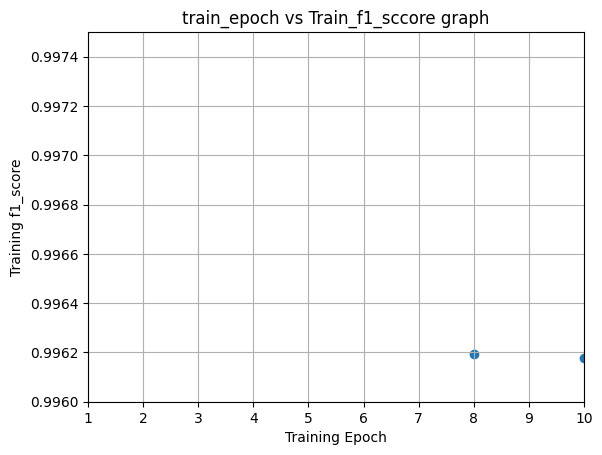

In [53]:
import matplotlib.pyplot as plt

plt.scatter(train_epoch, train_f1_score)
plt.xlabel("Training Epoch")
plt.ylabel("Training f1_score")
plt.title("train_epoch vs Train_f1_sccore graph")
plt.grid(True)
plt.xlim(1,12)
plt.ylim(0.995,0.999)

plt.show()
